In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import pickle
import re
from itertools import combinations
from adjustText import adjust_text

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data
    

In [17]:
data_root = './data/cities_json'
bios_path = './data/all_bios_embeddings.csv'
figure_folder = '/home/jonno/Dropbox/Apps/Overleaf/Metropolitan 400/figures/'

In [18]:
files = os.listdir(data_root+'/London')

In [19]:
files[0]

'Wealth-X Hamad bin Khalifa bin Hamad bin Abdullah bin Jassim Al Thani Dossier.pkl'

Cite this in the network write up

GPT-NER: Named Entity Recognition via Large Language Models
https://arxiv.org/abs/2304.10428




In [20]:
example = load_pickle_file(data_root+'/London/' + files[1])

example.keys()

dict_keys(['biography', 'career_history', 'clubs_and_boards', 'philanthropy', 'known_associates', 'service_providers', 'family_details', 'summary'])

In [21]:
example['summary'].at[0,'Residences']

'London, Greater London, United Kingdom'

In [22]:
#The below lookup ensures that the reference country is always included in the list of countries
city_country_converter= pd.DataFrame({
    'reference_country':['united states', 'united states', 'united kingdom', 'nigeria', 'mexico', 'germany', 'south africa', 'hong kong', 'brazil', 'australia'],
'reference_city':['new york', 'san francisco','london', 'lagos', 'mexico city', 'frankfurt',  'johannesburg', 'hong kong', 'rio de janeiro', 'sydney']}
)

city_country_converter['color'] = 'red'


In [23]:
def extract_residences(file_path):

    """
    Extracts the 'Residences' information from a pickle file.

    This function attempts to load a pickle file located at the specified file path.
    It extracts the 'Residences' data from the 'summary' section of the loaded file.
    Additionally, it captures any errors encountered during the extraction process.

    Parameters:
    - file_path (str): The path to the pickle file from which to extract the 'Residences' information.

    Returns:
    - pd.DataFrame: A DataFrame containing the following columns:
        - 'file': The name of the file from which the 'Residences' information was extracted.
        - 'error': A boolean indicating whether an error was encountered during extraction.
        - 'Residences': The extracted 'Residences' information, if available; otherwise, None.

    Raises:
    - KeyError: If the 'summary' or 'Residences' key is not found in the pickle file.
    - TypeError: If the file loaded is not a pickle file or is improperly formatted.
    """

    # Try to load the pickle file
    try:
        temp_dict = load_pickle_file(file_path)
        residences = temp_dict['summary'].at[0,'Residences']
        error = False
    except (KeyError, TypeError):
        residences = None
        error = True

    # Extract file name from the file path
    file_name = file_path.split('/')[-1]
    
    # Return the desired DataFrame
    df = pd.DataFrame({
        'file': [file_name],
        'error': [error],
        'Residences': [residences]
    })
    
    return df

def process_files(files_list):
    """
    Processes a list of file paths to extract 'Residences' information from each.

    This function iterates over a given list of file paths, calling the 'extract_residences'
    function on each file to extract the 'Residences' information. The results are concatenated
    into a single DataFrame.

    Parameters:
    - files_list (list of str): A list of file paths to be processed.

    Returns:
    - pd.DataFrame: A DataFrame containing the combined results from all files in the list.
      It includes the following columns:
        - 'file': The name of each file processed.
        - 'error': A boolean indicating whether an error was encountered during extraction
                   for each file.
        - 'Residences': The extracted 'Residences' information from each file, if available;
                        otherwise, None.

    Notes:
    - The function assumes that the 'extract_residences' function is defined and accessible.
    - The resulting DataFrame will have a boolean 'error' column, and its dtype is set accordingly.
    """

    # Create an empty DataFrame
    combined_df = pd.DataFrame(columns=['file', 'error', 'Residences'])
    combined_df['error'] = combined_df['error'].astype(bool)
    # Loop through the list of files and concatenate DataFrames
    for file_path in files_list:
        df_result = extract_residences(file_path)
        combined_df = pd.concat([combined_df, df_result], ignore_index=True)
    
    return combined_df


def extract_cities(target_df, reference_df, ref_type='city_ascii', ref_col = 'reference_city'):

    """
    Extracts a list of city names from a target DataFrame based on a reference DataFrame.

    This function processes the 'Residences' column in the target DataFrame, extracting city names
    that match any city name in the reference DataFrame. The reference DataFrame must have a column
    with city names specified by the 'ref_type' parameter. The resulting lists of city names are 
    added as a new column to the target DataFrame.

    Parameters:
    - target_df (pd.DataFrame): The DataFrame containing the 'Residences' column from which city names are to be extracted.
    - reference_df (pd.DataFrame): The reference DataFrame containing city names.
    - ref_type (str, optional): The column name in the reference DataFrame that contains city names. Defaults to 'city_ascii'.
    - ref_col (str, optional): The column name in the reference DataFrame that contains the reference city/country names. Defaults to 'reference_city'.

    Returns:
    - pd.DataFrame: The target DataFrame with an added column named '<ref_type>_list', containing lists of extracted city names.

    Raises:
    - KeyError: If the 'ref_type' column is not found in the reference DataFrame or if 'Residences' is not found in the target DataFrame.

    Notes:
    - The function creates a regular expression pattern to identify city names in the 'Residences' column.
    - City names that contain special characters like "." or "+" are properly escaped for regex matching.
    - Only unique city names are retained in the resulting lists for each row in the target DataFrame.
    - The function operates on copies of the provided DataFrames and does not modify the originals.
    """

    target_df = target_df.copy()
    reference_df = reference_df.copy()
    
    # Convert the reference cities to a list and filter out any empty or whitespace-only strings
    city_list = [city for city in reference_df[ref_type].tolist() if city and city.strip()]
    
    # Ensure that city names that contain special characters like "." or "+" are properly escaped for regex
    city_list = [re.escape(city) for city in city_list]
    
    # Create a regex pattern using the city_list
    pattern = r'\b(' + '|'.join(city_list) + r')\b'
    
    # Extract cities from the target dataframe using the pattern
    target_df[ref_type+'_list'] = target_df['Residences'].str.findall(pattern)
    
    # Convert 'reference_city' to a list containing a single element (the city)
    target_df['reference_city_list'] = target_df[ref_col].apply(lambda x: [x])
    
    # Add the city from 'reference_city' column to the list
    target_df[ref_type+'_list'] += target_df['reference_city_list']
    
    # Ensure unique cities by converting list to set and then back to list
    target_df[ref_type+'_list'] = target_df[ref_type+'_list'].apply(lambda x: list(set(x)))
    
    # Drop the temporary 'reference_city_list' column
    target_df.drop('reference_city_list', axis=1, inplace=True)
    
    return target_df


def binary_representation(df, column_name):

    """
    Transforms a column in the DataFrame containing lists of items into a binary representation.

    This function takes a DataFrame and a column name as input. The column should contain lists
    of items (e.g., countries, cities). It then transforms this column into a binary
    representation where each unique item in the lists gets its own column in the DataFrame. 
    If an item is present in the list for a row, the corresponding column will have a value of 1;
    otherwise, 0.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be transformed.
    - column_name (str): The name of the column containing lists of items.

    Returns:
    - pd.DataFrame: A new DataFrame with the original column replaced by a set of binary columns,
                    one for each unique item found in the lists of the original column.

    Notes:
    - The function creates a copy of the input DataFrame to avoid modifying the original DataFrame.
    - The original column containing lists is dropped after transformation.
    """

    df = df.copy()

    # Get unique countries/cities from the dataframe
    unique_items = set(item for sublist in df[column_name] for item in sublist)
    
    # Create binary columns for each unique country/city and store them in a list
    new_cols = []
    for item in unique_items:
        new_cols.append(df[column_name].apply(lambda x: 1 if item in x else 0).rename(item))
    
    # Concatenate the new columns to the original DataFrame
    df = pd.concat([df] + new_cols, axis=1)
    
    # Drop the original column
    df = df.drop(column_name, axis=1)
    
    return df


def create_city_network(df, column_name):
    """
    Creates a network (graph) representation of connections between cities.

    This function takes a DataFrame and a column name as input. The specified column should
    contain lists of cities. A graph is then constructed where each city represents a node,
    and edges are created between cities that appear together in the same list. The weight of
    an edge represents the number of times two cities appear together, and the inverse weight
    is calculated as max + 1 - weight.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the city lists.
    - column_name (str): The name of the column containing lists of cities.

    Returns:
    - nx.Graph: A networkx Graph object representing the city network. Nodes correspond to cities,
                and edges connect cities that appear together in the lists. Edge weights represent
                the frequency of co-occurrence and the inverse weight is also calculated.

    Notes:
    - The function assumes that the 'combinations' function from the 'itertools' module and the
      'nx' (networkx) module are imported.
    - If two cities appear together more than once across the lists, the corresponding edge's
      weight is incremented accordingly.
    """

    G = nx.Graph()
    
    for city_list in df[column_name]:
        # For each list of cities, generate pairs of cities
        for city1, city2 in combinations(city_list, 2):
            if G.has_edge(city1, city2):
                # If the edge already exists, we increase the edge weight
                G[city1][city2]['weight'] += 1
            else:
                # If the edge doesn't exist, we add it with weight 1
                G.add_edge(city1, city2, weight=1)
    
    max_weight = max(nx.get_edge_attributes(G, 'weight').values())
    for u, v, data in G.edges(data=True):
        # Calculate inverse weight as an integer and assign it
        data['inv_weight'] = int(max_weight + 1 - data['weight'])
    
    return G

# City color pallette

The color pallette is created here to ensure consistent colors scheme for cities



In [24]:
# Create a color mapping dictionary to assign the same color to each category

cities_list = ['Frankfurt', 'Hong Kong', 'Johannesburg', 'Lagos', 'London',
       'Mexico City', 'New York', 'Rio de Janeiro', 'San Francisco',
       'Sydney']
palette = sns.color_palette("Set3", len(cities_list))
color_mapping = {category: palette[i] for i, category in enumerate(cities_list)}


# Load list of cities and countries

This loads a csv from 'simplemaps' which contains a large number of global cites. the 10 largest cities are taken from each country

In [25]:
cities_df = pd.read_csv('./data/simplemaps_worldcities_basicv1.76/worldcities.csv')

cities_df = cities_df.groupby('country', group_keys=False).apply(lambda g: g.nlargest(50, 'population')).reset_index(drop=True)
cities_df['city_ascii'] = cities_df['city_ascii'].str.lower()
cities_df['country'] = cities_df['country'].str.lower()
cities_df = cities_df.loc[cities_df['population']>100000,:]

cities_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Kabul,kabul,34.5253,69.1783,afghanistan,AF,AFG,Kābul,primary,4273156.0,1004993580
1,Kandahār,kandahar,31.6200,65.7158,afghanistan,AF,AFG,Kandahār,admin,614254.0,1004003059
2,Herāt,herat,34.3419,62.2031,afghanistan,AF,AFG,Herāt,admin,556205.0,1004237782
3,Farāh,farah,32.3436,62.1194,afghanistan,AF,AFG,Farāh,admin,500000.0,1004523791
4,Mazār-e Sharīf,mazar-e sharif,36.7000,67.1167,afghanistan,AF,AFG,Balkh,admin,469247.0,1004436363
...,...,...,...,...,...,...,...,...,...,...,...
7088,Harare,harare,-17.8292,31.0522,zimbabwe,ZW,ZWE,Harare,primary,2150000.0,1716196799
7089,Bulawayo,bulawayo,-20.1700,28.5800,zimbabwe,ZW,ZWE,Bulawayo,admin,653337.0,1716032632
7090,Chitungwiza,chitungwiza,-17.9939,31.0481,zimbabwe,ZW,ZWE,Harare,NaN,371244.0,1716688236
7091,Mutare,mutare,-18.9667,32.6333,zimbabwe,ZW,ZWE,Manicaland,admin,224802.0,1716060405


In [26]:
cities_df.loc[cities_df['city_ascii'].str.contains('san$', case=False, na=False),:]

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4660,Wŏnsan,wonsan,39.1475,127.4461,north korea,KP,PRK,Kangwŏn,admin,363127.0,1408692125
4672,Hyesan,hyesan,41.4000,128.1833,north korea,KP,PRK,Ryanggang,admin,192680.0,1408642146
5756,Busan,busan,35.1800,129.0750,south korea,KR,KOR,Busan,admin,3453198.0,1410601465
5762,Ulsan,ulsan,35.5500,129.3167,south korea,KR,KOR,Ulsan,admin,1166033.0,1410134602
5771,Ansan,ansan,37.3167,126.8333,south korea,KR,KOR,Gyeonggi,NaN,652800.0,1410585171
5779,Masan,masan,35.1833,128.5500,south korea,KR,KOR,Gyeongnam,NaN,429612.0,1410394650
5787,Asan,asan,36.7833,126.9833,south korea,KR,KOR,Chungnam,NaN,332790.0,1410521090
5789,Asan,asan,36.3500,126.9167,south korea,KR,KOR,Chungnam,NaN,319929.0,1410904940
5792,Iksan,iksan,35.9439,126.9544,south korea,KR,KOR,Jeonbuk,NaN,302310.0,1410134391
5793,Yangsan,yangsan,35.3333,129.0333,south korea,KR,KOR,Gyeongnam,minor,297532.0,1410795549


# Load and process residence information

In [27]:
all_data_df = []

for city in os.listdir(data_root):
    print(city)
    files = os.listdir(data_root+'/'+city)
    city_temp = process_files([data_root+'/'+city+'/' +x for x in files])

    city_temp['reference_city'] = city.lower()
    all_data_df.append(city_temp)

all_data_df = pd.concat(all_data_df, ignore_index=True)

all_data_df['reference_city'] = all_data_df['reference_city'].replace('san francisco bay area', 'san francisco')

all_data_df['Residences'] = all_data_df['Residences'].str.lower()

all_data_df = all_data_df.merge(city_country_converter, how='left', on='reference_city')

missing_data = all_data_df.loc[all_data_df['error']==True,:].copy()

all_data_df = extract_cities(all_data_df.loc[all_data_df['error']!=True,:], cities_df)
all_data_df = extract_cities(all_data_df, cities_df, 'country', 'reference_country')




Lagos
Johannesburg
Hong Kong
Rio de Janeiro
San Francisco Bay Area
Mexico City
Frankfurt
London
Sydney
New York


In [28]:
binary_country_df = binary_representation(all_data_df.loc[all_data_df['reference_country']==ref_country,:], 'country_list')

binary_country_df = binary_country_df.drop(['file', 'error', 'Residences', 'reference_city', 
                                                'city_ascii_list', 'reference_country', 'color', ref_country], axis = 1).sum(axis = 1)

binary_country_df 

NameError: name 'ref_country' is not defined

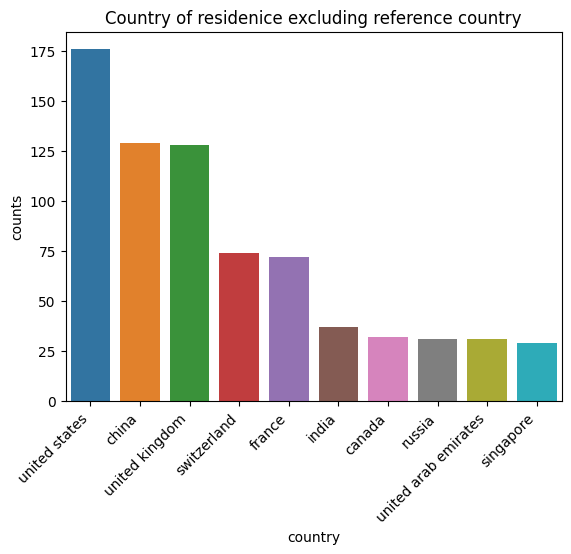

In [29]:
country_count_ex_ref = []

for ref_country in all_data_df['reference_country'].unique():

    binary_country_df = binary_representation(all_data_df.loc[all_data_df['reference_country']==ref_country,:], 'country_list')

    #The reference country needs to be dropped as well, perhaps binary_representation should be modified for better dropping?
    binary_country_df = binary_country_df.drop(['file', 'error', 'Residences', 'reference_city', 
                                                'city_ascii_list', 'reference_country', 'color', ref_country], axis = 1).sum(axis = 0)

    #binary_country_df = binary_country_df.drop(['file', 'error', 'Residences', 'reference_city', 'city_ascii_list', ref_country], axis = 1).sum(axis = 0)
    binary_country_df = binary_country_df.sort_values().reset_index().rename(columns={'index':'country', 0:'counts'})

    country_count_ex_ref.append(binary_country_df)

country_count_ex_ref = pd.concat(country_count_ex_ref, ignore_index=True).groupby('country').sum().reset_index()

sns.barplot(data = country_count_ex_ref.loc[:,:].nlargest(10, 'counts'), x = 'country', y = 'counts')
plt.title('Country of residenice excluding reference country')
plt.xticks(rotation=45, ha="right") 
plt.show()


In [30]:
binary_representation(all_data_df, 'country_list').to_csv('./data/country_residence_matrix.csv', index=False)


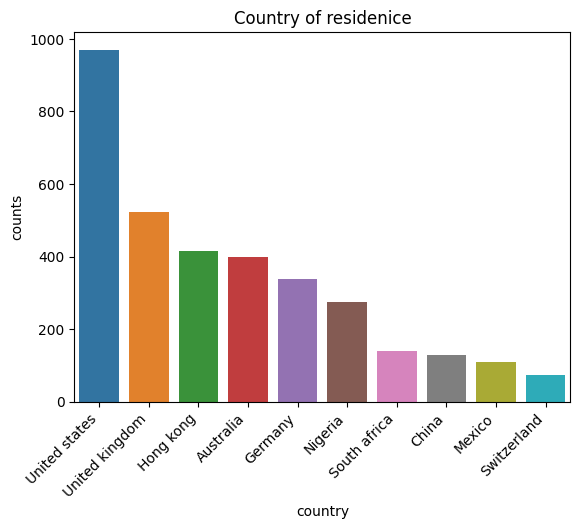

In [31]:
binary_country_df = binary_representation(all_data_df, 'country_list')

binary_country_df = binary_country_df.drop(['file', 'error', 'Residences', 'reference_city', 
                                                'city_ascii_list', 'reference_country', 'color'], axis = 1).sum(axis = 0).sort_values().reset_index().rename(columns={'index':'country', 0:'counts'})
binary_country_df['country'] = binary_country_df['country'].str.capitalize()
sns.barplot(data = binary_country_df.loc[:,:].nlargest(10, 'counts'), x = 'country', y = 'counts')
plt.title('Country of residenice')
plt.xticks(rotation=45, ha="right") 
plt.show()






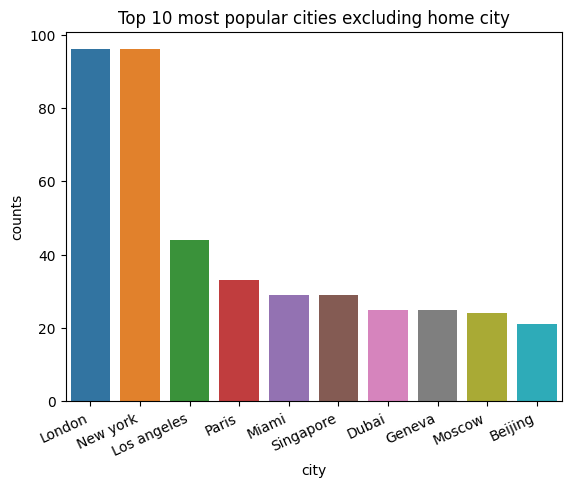

In [32]:
city_count_ex_ref = []

for ref_city in all_data_df['reference_city'].unique():

    binary_city_df = binary_representation(all_data_df.loc[all_data_df['reference_city']==ref_city,:], 'city_ascii_list')
    #The reference city needs to be dropped
    columns_to_drop = ['file', 'error', 'Residences', 'reference_city', 
                                                'country_list', 'reference_country', 'color']

    if ref_city in binary_city_df.columns:
        columns_to_drop.append(ref_city)

    binary_city_df = binary_city_df.drop(columns_to_drop, axis = 1).sum(axis = 0)
    binary_city_df = binary_city_df.sort_values().reset_index().rename(columns={'index':'city', 0:'counts'})

    city_count_ex_ref.append(binary_city_df)

city_count_ex_ref = pd.concat(city_count_ex_ref, ignore_index=True).groupby('city').sum().reset_index()

#fig = plt.figure(figsize=(8, 6))  
city_count_ex_ref = city_count_ex_ref.loc[~city_count_ex_ref['city'].isin(['california', 'australia', 'florida', 'mexico', 'colorado', 'kowloon', 'victoria'])
                                         ,:].nlargest(10, 'counts')
city_count_ex_ref['city'] = city_count_ex_ref['city'].str.capitalize()
sns.barplot(data = city_count_ex_ref , x = 'city', y = 'counts')
plt.title('Top 10 most popular cities excluding home city')
plt.xticks(rotation=25, ha="right") 

plt.savefig(figure_folder+"city_excluding_reference.pdf")
plt.show()



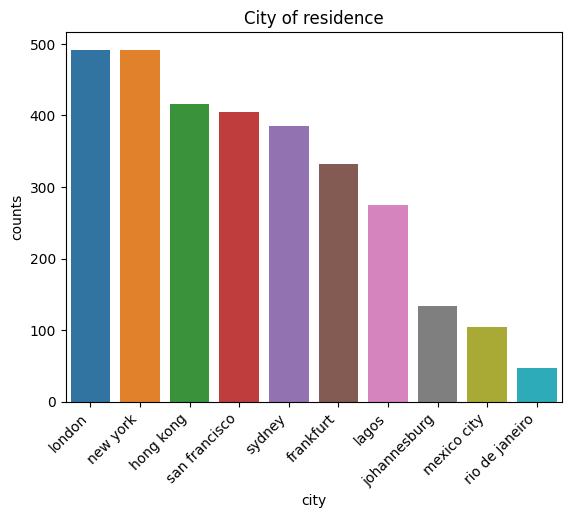

In [33]:
binary_city_df = binary_representation(all_data_df,'city_ascii_list')

binary_city_df = binary_city_df.drop(['file', 'error', 'Residences', 'reference_city', 
                                                'country_list', 'reference_country', 'color'], axis = 1).sum(axis = 0).sort_values().reset_index().rename(columns={'index':'city', 0:'counts'})

sns.barplot(data = binary_city_df.loc[:,:].nlargest(10, 'counts'), x = 'city', y = 'counts')
plt.title('City of residence')
plt.xticks(rotation=45, ha="right") 
plt.show()

# Network creation

We create a network that includes reference country

In [34]:


G = create_city_network(all_data_df, 'country_list')


In [35]:
# Get edge weights
edge_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

# Convert to a DataFrame
df = pd.DataFrame(edge_weights, columns=['Node1', 'Node2', 'Weight'])

df.sort_values('Weight', ascending=False).nlargest(20,'Weight').to_csv('./data/top_edge_weights.csv')

print(df.sort_values('Weight', ascending=False).nlargest(20,'Weight'))

              Node1                 Node2  Weight
22   united kingdom         united states     128
187           china             hong kong     106
26   united kingdom           switzerland      58
28   united kingdom                france      56
0           nigeria        united kingdom      51
109   united states             hong kong      43
104   united states                france      42
2           nigeria         united states      34
37   united kingdom                russia      30
35   united kingdom             hong kong      29
102   united states           switzerland      29
29   united kingdom          south africa      28
21   united kingdom                 india      27
101   united states                 china      25
196     switzerland                france      23
27   united kingdom  united arab emirates      22
111   united states             australia      19
263       hong kong             singapore      19
260       hong kong                canada      18


In [36]:
country = 'mexico'
df.loc[(df['Node1']==country)|(df['Node2']==country),:].sort_values('Weight', ascending=False)

,Node1,Node2,Weight
126,united states,mexico,12
170,spain,mexico,3
182,italy,mexico,1
314,germany,mexico,1
318,mexico,israel,1


# Analysing the betweeness centrality

There are 85 countries in the analysis.

Looking at the betweeness centrality of the countries we see that unsurprisingly the US and UK are the most high ranking. The UK is higher ranking than the US which is surprising given that the US has two cities in the analysis. This may be partly because the US ultra rich are less likely to have residences outside the US than the ultra rich from the other cities analysed. What is more surprising is the high betweeness centrality of France and Switzerland who do not have cities in the analysis. The reason for this high ranking is that Switzerland and France form a sort of connectivity square with the US and UK, that is all 4 countries are highly connected making Switzerland and France major secondary routes connecting the US and UK with the rest of the network. Switzerland is a traditionally popular with the global ultra rich due to it's history of tax free banking and secrecy. However, it appears that France is simply a popular place to live for the Ultra rich.

Canada, although it does not have a large number of ultra rich is closely connected to US, UK, and Hong Kong making it an important linking node. China is a key node due to the large number of international ukltra rich

A common concept in network analysis is network communities. These communities are quantifiable units where the nodes within a community are more closely related inthe network to nodes outside the community. Using the popular modularity based method th "Louvain aglorithm", 4 communities were detected. There were two main communities which together contain 95% of all the countries in the analysis. The communities are essentially split into East Asian and associated countries, and The rest of the world. The East Asian commnity contains 18 countries (21% of the dataset) including almost all the East Asian countries as well as Australia, Canada, Denmark, and Chile. These non-East Asian countries are appear to be in the community due to the strong co-occurance with Hong Kong and China. The Rest of the World community contains 63 countries (74% of the dataset). The final two communities contain two countries each Angola-Portugal, which is an unsurprising grouping, and Croatia-Mali which is most likely just statistical noise.

In [37]:
# Compute weighted betweenness centrality
betweenness = nx.betweenness_centrality(G, weight='inv_weight')

# Convert the dictionary to a DataFrame
betweenness_df = pd.DataFrame(list(betweenness.items()), columns=['Node', 'Weighted Betweenness Centrality']).sort_values('Weighted Betweenness Centrality', ascending=False)

betweenness_df.to_csv('./data/betweeness_centrality.csv')
betweenness_df.nlargest(20, 'Weighted Betweenness Centrality')

,Node,Weighted Betweenness Centrality
1,united kingdom,0.665997
3,united states,0.504255
19,hong kong,0.127893
0,nigeria,0.026391
10,switzerland,0.015060
11,france,0.009371
9,china,0.001865
42,brazil,0.000861
27,canada,0.000574
13,south africa,0.000550


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IndexError: list index out of range

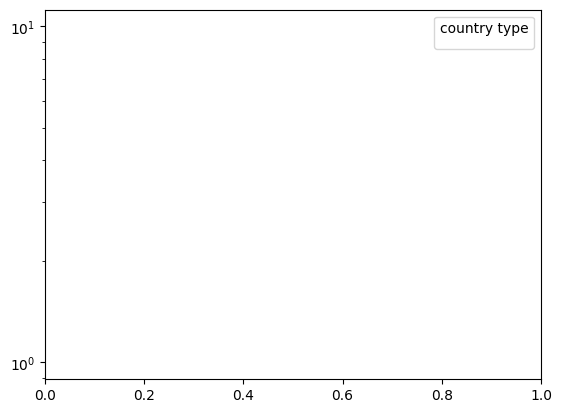

In [38]:
temp_df = betweenness_df.merge(binary_country_df,#country_count_ex_ref, 
                                left_on='Node', right_on='country')

temp_df['betweenness'] = np.where(temp_df['Weighted Betweenness Centrality'].rank(ascending=False)<=10, 'high','low')

temp_df['ref_country'] = np.where(temp_df['Node'].isin(city_country_converter['reference_country'].unique()), 'reference', 'other')

annotations_df = temp_df.loc[((temp_df['betweenness']=='high') |(temp_df['ref_country']=='reference')) & 
                             temp_df['Weighted Betweenness Centrality']>0,:].copy()

annotations_df['Node'] = annotations_df['Node'].str.title()

sns.scatterplot(data = temp_df,
                y = 'Weighted Betweenness Centrality', x = 'counts', hue = 'ref_country')

texts = []
for idx, row in annotations_df.iterrows():
    texts.append(plt.text(temp_df.loc[idx, 'counts'], temp_df.loc[idx, 'Weighted Betweenness Centrality'], row['Node']))

plt.yscale('log')
plt.legend(title='country type')

adjust_text(texts)     

plt.title('Relationship between residence\ncountry counts and their network centrality')


plt.savefig(figure_folder+"network_centrality_count.pdf")
plt.show()
plt.close()
 

NameError: name 'comms' is not defined

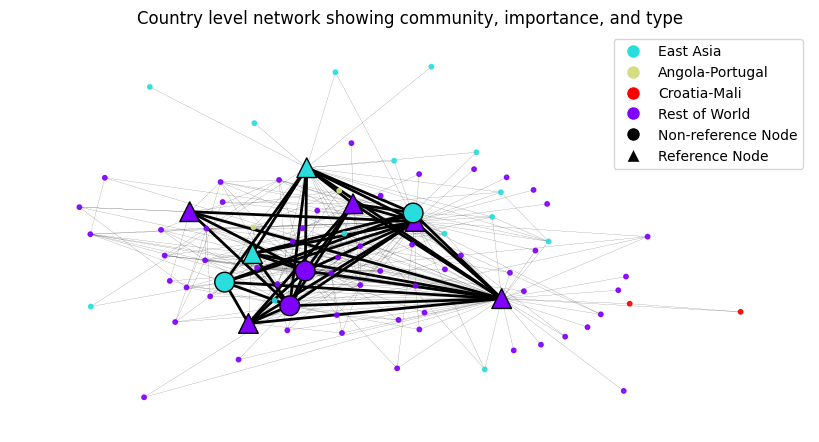

In [39]:
# Calculate Louvain communities
comms = nx.community.louvain_communities(G, seed=123)

# Assuming G is your graph and city_country_converter is defined
node_color_dict = dict(city_country_converter[['reference_country', 'color']].values)

# Calculate betweenness centrality
centrality_value = nx.betweenness_centrality(G, weight='inv_weight')


# Map nodes to community index
node_community_dict = {}
for i, comm in enumerate(comms):
    for node in comm:
        node_community_dict[node] = i

# Determine the community colors
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(comms)))

# Assign community colors to all nodes
node_community_colors_all = [community_colors[node_community_dict[node]] for node in G.nodes()]

# Positions for all nodes
positions = nx.kamada_kawai_layout(G, scale=5)

fig = plt.figure(figsize=(8, 4)) 
# Draw all nodes and edges with faint lines and nodes colored by community
nx.draw(G, with_labels=False, node_color=node_community_colors_all,
        node_size=10, pos=positions, width=0.1, alpha=0.9)

# Draw non-zero centrality nodes and their edges with normal style
non_zero_centrality_nodes = [node for node in G.nodes() if centrality_value[node] > 0]
node_community_colors_non_zero = [community_colors[node_community_dict[node]] for node in non_zero_centrality_nodes]
node_sizes_non_zero = [200 for node in non_zero_centrality_nodes]

# Determine node shapes based on color
node_shapes = ['o' if node_color_dict.get(node) != 'red' else '^' for node in non_zero_centrality_nodes]

# Draw nodes with community colors and different shapes for non-zero centrality nodes
for shape in set(node_shapes):
    filtered_nodes = [node for node, s in zip(non_zero_centrality_nodes, node_shapes) if s == shape]
    filtered_sizes = [size for node, size in zip(non_zero_centrality_nodes, node_sizes_non_zero) if node in filtered_nodes]
    filtered_colors = [color for node, color in zip(non_zero_centrality_nodes, node_community_colors_non_zero) if node in filtered_nodes]
    
    nx.draw_networkx_nodes(G.subgraph(filtered_nodes),
                           positions,
                           node_size=filtered_sizes,
                           node_color=filtered_colors,
                           node_shape=shape,
                           nodelist=filtered_nodes,
                           linewidths=1.0,
                           edgecolors='black')

# Draw edges for non-zero centrality nodes
nx.draw_networkx_edges(G.subgraph(non_zero_centrality_nodes),
                       positions,
                       width=2,
                       alpha=1)

community_names = {
    1: "East Asia",
    2: "Angola-Portugal",
    3: "Croatia-Mali"
    # Other communities, if any
}

# Define custom legend entries
legend_elements = []
for i, color in enumerate(community_colors):
    if i in community_names:  # Only add if community has a specific name
        community_name = community_names[i]
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=community_name,
                                      markerfacecolor=color, markersize=10))

# Add "Rest of World" as the last entry
rest_of_world_color = community_colors[0]  # Assuming the first color corresponds to "Rest of World"
legend_elements.append(Line2D([0], [0], marker='o', color='w', label="Rest of World",
                              markerfacecolor=rest_of_world_color, markersize=10))


# Add custom legend entries for shapes
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Non-reference Node',
                              markerfacecolor='black', markersize=10))
legend_elements.append(Line2D([0], [0], marker='^', color='w', label='Reference Node',
                              markerfacecolor='black', markersize=10))

# Draw legend
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Country level network showing community, importance, and type')

plt.savefig(figure_folder+"network_communities.pdf")
plt.show()


In [40]:
# Get connected components
connected_components = list(nx.connected_components(G))

# Calculate the number of nodes in each component
component_node_counts = [len(component) for component in connected_components]

print(component_node_counts)

[85]


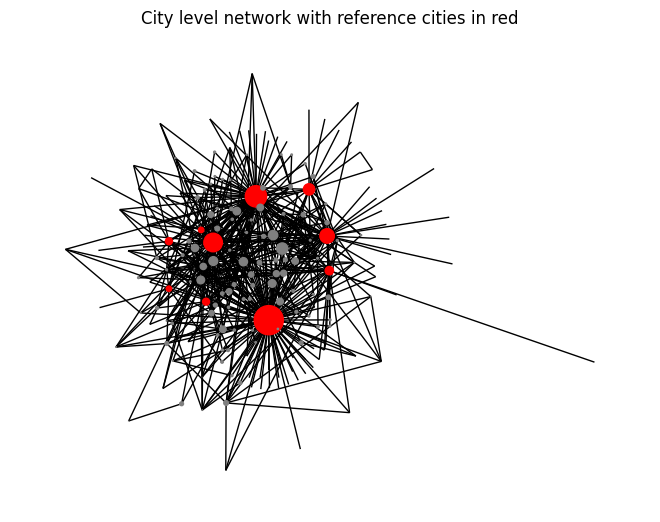

In [41]:
G = create_city_network(all_data_df, 'city_ascii_list')
color_map = dict(zip(city_country_converter['reference_city'], city_country_converter['color']))

#edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 1]
#G.remove_edges_from(edges_to_remove)


# Create a list of colors for each node using the color_map dictionary
node_color_dict = dict(city_country_converter[['reference_city', 'color']].values)
node_colors = [node_color_dict.get(node, 'gray') for node in G.nodes()]

centrality_value = nx.betweenness_centrality(G, weight='weight')

# Scale centrality values to set node sizes (e.g., multiply by 1000 for better visualization)
node_sizes = [centrality_value[node] * 1000 for node in G.nodes()]


# Draw the graph
nx.draw(G, with_labels=False, node_color=node_colors, node_size=node_sizes, pos = nx.kamada_kawai_layout(G,scale=5))
plt.title('City level network with reference cities in red')
plt.show()

In [42]:
# Get edge weights
edge_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

# Convert to a DataFrame
df = pd.DataFrame(edge_weights, columns=['Node1', 'Node2', 'Weight'])

df.sort_values('Weight', ascending=False).nlargest(20,'Weight')#.to_csv('./data/top_edge_weights.csv')


,Node1,Node2,Weight
14,london,new york,76
11,london,lagos,45
190,new york,san francisco,35
343,hong kong,kowloon,32
183,new york,los angeles,26
13,london,paris,22
34,london,moscow,22
50,london,geneva,21
182,new york,hong kong,19
178,new york,miami,19
